In [2]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import torch

import sys
import os
import random

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
            
# data (as pandas dataframes) 
wine_quality = fetch_ucirepo(id=186) 
        
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = X.to_numpy()
y = y.to_numpy()

nbrs = NearestNeighbors(n_neighbors=50).fit(X)
idxs = nbrs.kneighbors(X, return_distance=False)
coefs = []
for neigh in idxs[::100]:  # 每隔 100 个样本检查一次
    lr = LinearRegression().fit(X[neigh], y[neigh])
    coefs.append(lr.coef_)
coefs = np.array(coefs)  # shape (50, 20)
# 查看各维度系数的方差
var_coef = coefs.var(axis=0)
print("局部回归系数方差最大的前五维：", np.argsort(var_coef)[-5:])


局部回归系数方差最大的前五维： [[ 6  5  3  0 10  2  9  1  8  4  7]]


In [12]:
var_sort = np.sort(var_coef)
var_sort[0][-5:]

array([2.19093285e+00, 2.42293141e+00, 3.53426121e+00, 1.12711571e+02,
       1.11706140e+05])

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X, y)

# 查看首个分裂维度和阈值
feature = tree.tree_.feature[0]
threshold = tree.tree_.threshold[0]
print(f"首个分裂特征：x[{feature}]，阈值：{threshold:.3f}")

# 计算单模型 vs 分段模型的交叉验证得分
from sklearn.model_selection import cross_val_score
import numpy as np

mse_global = -cross_val_score(DummyRegressor(strategy='mean'), X, y, cv=5, scoring='neg_mean_squared_error').mean()
mse_piece  = -cross_val_score(tree, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(f"全局常数模型 MSE={mse_global:.3f}, 分段树模型 MSE={mse_piece:.3f}")


首个分裂特征：x[10]，阈值：10.625
全局常数模型 MSE=0.768, 分段树模型 MSE=0.614


In [17]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=2, random_state=42).fit_predict(X)

import scipy.stats as stats

g0 = y[labels==0]
g1 = y[labels==1]
f_stat, p_val = stats.f_oneway(g0, g1)
print(f"ANOVA F={f_stat.item():.3f}, p-value={p_val.item():.3g}")


ANOVA F=0.536, p-value=0.464


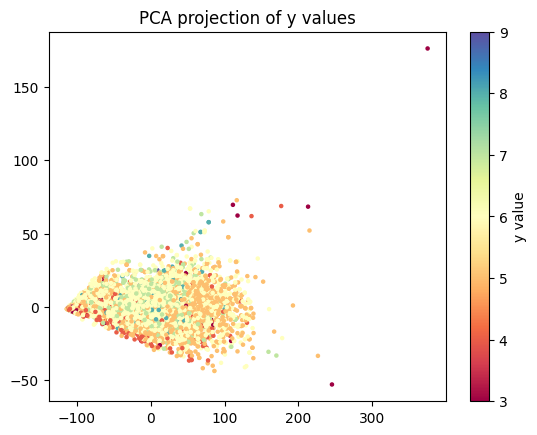

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X: (5000×20)，y: (5000,)
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

plt.scatter(X2[:,0], X2[:,1], c=y, cmap='Spectral', s=5)
plt.colorbar(label='y value')
plt.title('PCA projection of y values')
plt.show()


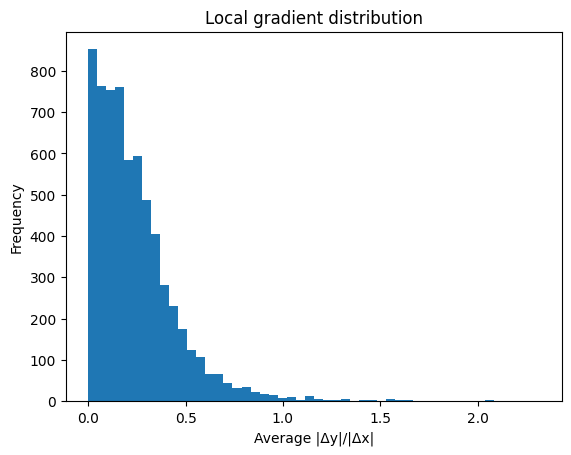

Threshold (percentile 98): 0.8492153780770024
Potential jump point indices: [   8   62  117  138  170  199  200  311  322  440  447  473  481  517
  566  567  576  582  589  600  618  626  627  638  647  688  690  702
  724  813  826  830  876  899 1000 1035 1040 1061 1142 1201 1202 1261
 1263 1299 1307 1374 1403 1449 1469 1482 1484 1485 1489 1494 1495 1498
 1505 1521 1549 1555 1667 1673 1737 1930 1975 1978 2101 2102 2240 2301
 2322 2419 2426 2443 2444 2472 2478 2497 2570 2621 2641 2751 2786 2828
 2865 2905 2957 2962 3001 3002 3008 3029 3178 3204 3218 3251 3314 3322
 3387 3395 3416 3641 3715 3824 3989 4051 4068 4262 4486 4587 4595 4602
 4666 4696 4788 5008 5016 5053 5261 5476 5500 5564 5711 5938 5988 6096
 6230 6378 6486]


In [21]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 假设你已有 X (5000×20) 和 y (5000,) 的 NumPy 数组
# 例如：
# X = np.loadtxt('X.csv', delimiter=',')
# y = np.loadtxt('y.csv', delimiter=',')

def detect_jumps(X, y, n_neighbors=5, percentile_threshold=98):
    # 构建 KNN 图
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    y = np.asarray(y).reshape(-1)
    
    # 计算每个点与其邻居间的局部梯度 |Δy|/|Δx|
    gradients = np.abs(y[:, None] - y[indices]) / (distances + 1e-8)
    # 对每个点取平均梯度作为其“跳跃”强度
    local_gradients = gradients.mean(axis=1)
    
    # 绘制直方图查看梯度分布
    plt.hist(local_gradients, bins=50)
    plt.title('Local gradient distribution')
    plt.xlabel('Average |Δy|/|Δx|')
    plt.ylabel('Frequency')
    plt.show()
    
    # 根据分位数阈值识别潜在跳跃点
    threshold = np.percentile(local_gradients, percentile_threshold)
    jump_indices = np.where(local_gradients > threshold)[0]
    
    return local_gradients, threshold, jump_indices

# 调用函数并展示结果
local_gradients, threshold, jump_indices = detect_jumps(X, y)
print(f"Threshold (percentile {98}):", threshold)
print("Potential jump point indices:", jump_indices)


c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packag

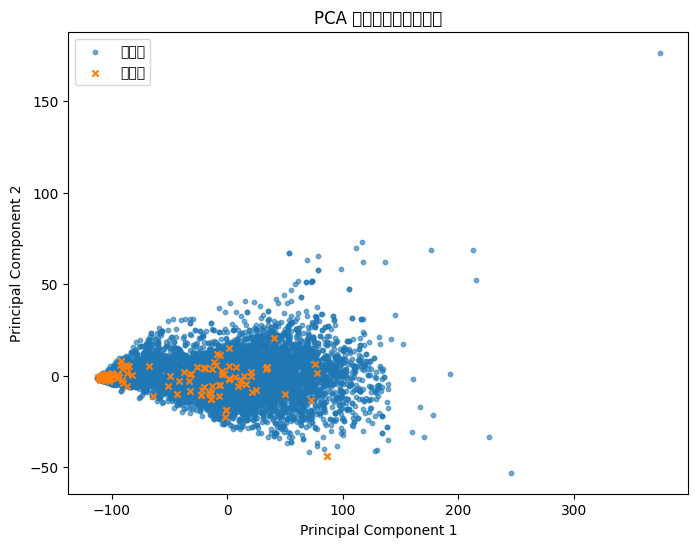

In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 假设你已有 X (5000×20) 和 y (5000,) 的 NumPy 数组
# X = np.load('X.npy')  # 或者 np.loadtxt('X.csv', delimiter=',')
# y = np.load('y.npy')  # 或者 np.loadtxt('y.csv', delimiter=',')

# 1. 计算局部平均梯度
nbrs = NearestNeighbors(n_neighbors=5).fit(X)
distances, indices = nbrs.kneighbors(X)
y1 = np.asarray(y).reshape(-1)
gradients = np.abs(y1[:, None] - y1[indices]) / (distances + 1e-8)
local_gradients = gradients.mean(axis=1)

# 2. 阈值筛选高梯度点（如第 98 百分位）
threshold = np.percentile(local_gradients, 98)
mask_high = local_gradients > threshold

# 3. 用 PCA 将输入降到 2 维
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

# 4. 可视化：低梯度点用圆点，高梯度点用叉号
plt.figure(figsize=(8, 6))
plt.scatter(X2[~mask_high, 0], X2[~mask_high, 1], s=10, label='低梯度', alpha=0.6)
plt.scatter(X2[mask_high, 0], X2[mask_high, 1], marker='x', s=20, label='高梯度')
plt.title('PCA 投影：高梯度点标记')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


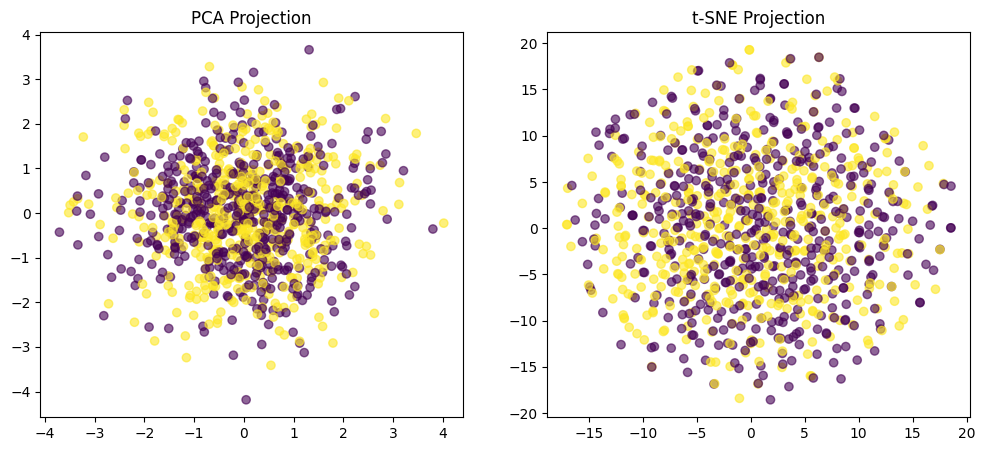

In [25]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 生成示例数据（假设X是高维数据，y是标签）
np.random.seed(42)
X = np.random.randn(1000, 50)  # 1000个样本，50维
y = np.random.randint(0, 2, 1000)  # 二分类标签

# PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE降维（适合非线性结构）
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

# 可视化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.6)
plt.title("PCA Projection")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, alpha=0.6)
plt.title("t-SNE Projection")
plt.show()

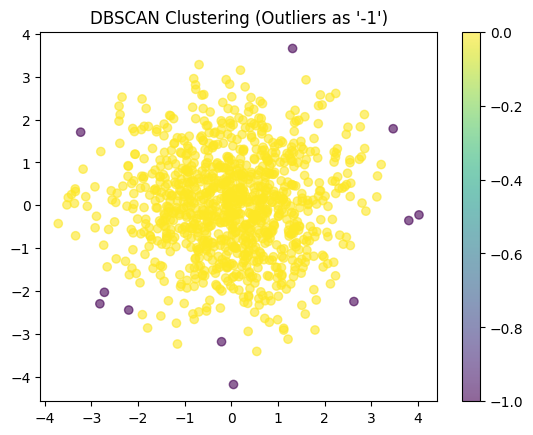

In [26]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 标准化数据
X_scaled = StandardScaler().fit_transform(X_pca)  # 使用PCA降维后的数据

# DBSCAN检测异常点（低密度区域为突变点）
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# 可视化
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("DBSCAN Clustering (Outliers as '-1')")
plt.colorbar()
plt.show()

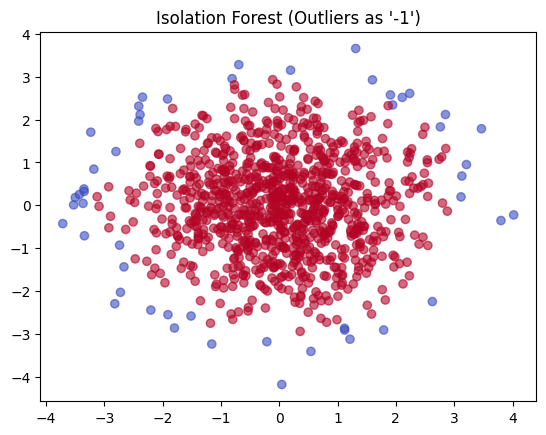

In [27]:
from sklearn.ensemble import IsolationForest

# 检测异常点
iso = IsolationForest(contamination=0.05)  # 假设5%异常
outliers = iso.fit_predict(X_scaled)

# 可视化
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=outliers, cmap='coolwarm', alpha=0.6)
plt.title("Isolation Forest (Outliers as '-1')")
plt.show()